__1. Какая стратегия поведения в листьях решающего дерева приводит к меньшей вероятности ошибки: выдавать в ответе тот класс, который преобладает в листе, или отвечать случайно с тем же распределением классов, что и в листе? Считайте, что рассматривается задача многоклассовой классификации.__

Допустим мы имеем три класса с долями a,b,c (a>b>c, a+b+c =1).
Частота ошибок классификации для объектов в листе в случае выдачи решающим правилом преобладающего в листе класса вычисляется как 1 — a. 
Математическое ожидание частоты ошибок классификации в случае выдачи решающим правилом случайного класса из распределения классов в листе  равно индексу Джинни:  $1 — (a^2+b^2+c^2)$.

 Докажем, что $a  >  a^2 + b^2 + c^2$:
		      $$1  >  a+ b^2/a + c^2/a$$
		       $$b^2 < ab,  c^2 < ac$$
		       $$b^2/a < b,  c^2/a < c$$
		     $$ a+b+c = 1 >  a  +  b^2/a  +  c^2/a.$$
Математическое ожидание частоты ошибок классификации при выдаче случайного ответа из распределения классов выше, чем частота ошибок при выдачи класса с преобладающей долей.  

__2. При обучении SVM с линейным ядром на наборе данных с очень большим числом разреженных признаков точность многоклассовой классификации на тестовой выборке получилась равной 95%, а при обучении SVM с радиальным ядром — 34%. Почему SVM с более сложным ядром показал менее высокое качество? Когда можно ожидать от радиального ядра улучшения качества по сравнению с линейным?__
		       

Радиальное ядро выражается через евклидово расстояние, а значит наследует все проблемы метрических алгоритмов, в том числе подвержено «проклятью размерности».
Разреженность признаков, видимо, говорит об относительной «легкости» решения задачи максимизации ширины разделяющей полосы для линейного ядра. 
Таким образом для улучшения качества классификации алгоритма с радиальным ядром признаков должно быть меньше и они должны быть «плотнее».



__3. В одном проекте заказчик очень хотел, чтобы исследователь решал не поставленную задачу классификации на классы 0 и 1, а задачу регрессии на тех же метках с модулем отклонения в качестве функции потерь. Замысел заказчика был в том, что оцененные числа получатся дробными, и это будет приближением для вероятности класса 1. Считая, что алгоритм старается минимизировать математическое ожидание потерь при условии известного объекта x, выясните, какими будут получаться прогнозы при такой функции потерь и насколько они будут соответствовать замыслу заказчика.__

Минимизация функционала ошибки с модулем отклонения мы получаем оценку медианы med(y|x). Кроме того на некоторых объектах значения $y = <w,x>$  будут выходить за границы интервала (0,1).

Для оценки мат. ожидания E(y|x) должна применятся квадратичная функция потерь. Для оценки квантилей X_t(y|x) несимметричный модуль отклонения. 

__4. Какой должна быть функция потерь в предыдущей задаче, чтобы действительно оценивались вероятности? Покажите, что это так?__

Т.к. на некоторых объектах значения $y = <w,x>$  будут выходить за границы интервала (0,1) для построения функции потерь нужно использовать функцию f отображающую множество действительных чисел R на интервал (0,1)  например сигмоиду $f(x)  =  1 / (1 + e^{- <w,x>})$, значения которой уже можно рассматривать вероятность принадлежности объекта x к классу +1  P(y = 1|x). 
Функция потерь построенная на основе сигмоиды называется log-loss или кросс-энтропия. 


__5. Когда в задаче бинарной классификации предпочтительней использовать ROC-AUC, а не accuracy? Как изменится ROC-AUC решения задачи бинарной классификации, если умножить все прогнозы на 2?__

В задачах с дисбалансом классов.
ROC-AUC не изменится. 






In [17]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
from scipy import stats
import statsmodels.stats.proportion as proportion
from statsmodels.stats.weightstats import _tconfint_generic
import matplotlib.pyplot as plt
from scipy.stats import powerlognorm, probplot, ttest_ind, norm
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib



##  Задача

    Имеется файл log.txt размером 1Tb, содержащий лог в следующем формате: номер записи, тип запроса, время отклика. Пример начала лога:
    1,/index,0.06
    2,/test,0.03
    3,/home,0.561
    4,/home,0.87
    5,/index,1.02
    Напишите на Python программу, которая для каждого типа запроса подсчитывает среднее время отклика и 95% доверительный интервал для этой величины. Реализуйте также проверку гипотезы о равенстве средних времен отклика для типов запроса /index и /test на уровне значимости 5%.

In [3]:
def log_progress(sequence, every=10):
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index,
        yield item

In [30]:
def get_test_data(universe_path,count):
    block_size = 100000
    
    # дискретное распределение для генерации меток {0:'/index', 1:'/home', 2: '/test'}
    xk = np.arange(3)
    pk = (0.6, 0.3, 0.1)
    custm = stats.rv_discrete(name='custm', values=(xk, pk))
        
    for i in log_progress(xrange(0,count/block_size)):
        data = pd.DataFrame(columns = ['group', 'response'])
        group = custm.rvs(size=block_size) 
        data['group'] = pd.Series(group).replace({0:'/index', 1:'/home', 2: '/test'})

        # генерация значений откликов из powerlognorm распределений
        index_mask = (data.group=='/index')
        home_mask =  (data.group=='/home')
        test_mask =  (data.group=='/test')

        data.iloc[index_mask.values,1] = powerlognorm.rvs(6, 1.3,0,1.4,size=sum(index_mask))
        data.iloc[home_mask.values,1] =  powerlognorm.rvs(7, 1.3,0,2.0,size=sum(home_mask))
        data.iloc[test_mask.values,1] =  powerlognorm.rvs(4, 1.3,0,1.9,size=sum(test_mask))
        data.index = xrange(i*block_size,i*block_size+block_size)
        data.to_csv(universe_path, header=False, mode='a+')
        del data
        del group

In [31]:
%time get_test_data('universe.csv',10000000)

 0 10 20 30 40 50 60 70 80 90

CPU times: user 2min 40s, sys: 4.16 s, total: 2min 44s
Wall time: 2min 51s


In [32]:
'''
Генеральную  совокупность (терабайтный файл) будет предствалять выборка из этой генеральной совокупности,
на основе которой и будут расcчитаны доверительные интервалы и проверены гипотезы.

Я полагаю, что нельзя просто брать первые n записей из лога, ведь они, наверняка, пишутся по мере поступления,
следовательно первые записи могут приходиться на промежуток времени, когда сервер был недогружен или перегружен
и выборка получится не представительной.
'''

def get_selection(universe_path,selection_path, count):
    """
    Функция принимает:
        путь к терабайтному файлу,
        путь к формируемому файлу выборки,
        количество элементов в выборке. 
    """
    size = os.path.getsize(universe_path)-100
    positions = sort(np.random.random_integers(0,size,count)) 
    #positions = np.random.random_integers(0,size,count)
    # np.random.random_integers - дискретное равномерное распределение. 
    f = open(universe_path, 'r')
    d = open(selection_path,'w')
    for i in positions:
        f.seek(i)  
        f.readline()
        d.write(f.readline())
    f.close()
    d.close()

In [33]:
%time get_selection('universe.csv','new.csv', 200000)
df_selection = pd.read_csv('new.csv',header=-1,index_col='index', names =['index','group','response'] )

CPU times: user 4.08 s, sys: 8.37 s, total: 12.5 s
Wall time: 51.2 s


In [34]:
"""
По полученной выборке можно рассчитать доверительные интервалы для долей групп /index', '/home', '/test' 
если полагать их неизветсными и оценнить количество элементов каждой из групп в терабайтном файле. 
'wilson' - на случай доли одной из групп близкой к 1 или 0.
"""
print '95% доверительный интервал для доли группы /index :', \
proportion.proportion_confint( len(df_selection[df_selection.group =='/index']),\
                               len(df_selection), method = 'wilson')
print '95% доверительный интервал для доли группы /test :', \
proportion.proportion_confint( len(df_selection[df_selection.group =='/test']),\
                               len(df_selection), method = 'wilson')
print '95% доверительный интервал для доли группы /home :', \
proportion.proportion_confint( len(df_selection[df_selection.group =='/home']),\
                               len(df_selection), method = 'wilson')

95% доверительный интервал для доли группы /index : (0.59814632473285867, 0.60243982255001738)
95% доверительный интервал для доли группы /test : (0.099319203842911, 0.10195613749651557)
95% доверительный интервал для доли группы /home : (0.29707228341482433, 0.30108543488806333)


In [35]:
index_data = np.array(df_selection[df_selection.group =='/index']['response'])
test_data  = np.array(df_selection[df_selection.group =='/test'] ['response'])
home_data  = np.array(df_selection[df_selection.group =='/home'] ['response'])

In [ ]:
"""
Для проверки полученных выборок на нормальность воспольземся критерием Шапиро-Уилка.
"""

Критерий Шапиро-Уилка:

 $H_0\colon$ случайная величина "время отклика" распределена нормально
 
 $H_1\colon$ не нормально

In [36]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(index_data)

Shapiro-Wilk normality test, W-statistic: 0.787652, p-value: 0.000000


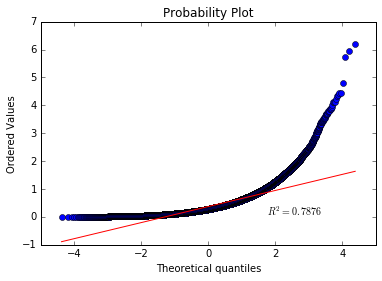

In [37]:
probplot(index_data,plot=plt,rvalue=True)
plt.show()

In [ ]:
"""
Cгенерированная из лог-нормального распределения тестовая выборка естесвенно не проходит тест на нормальность.
"""

# В случае нормальности распределений:

In [ ]:
"""
Если бы гипотеза о нормальности НЕ была отвегнута, мы могли бы сказать что выборки 
index_data, test_data, home_data взяты из бесконечных нормально распределенных генеральных 
совокупностей и для построения доверительного интервала можно использовать t-интервал,
а для проверки гипотезы о равенсве средних двух независимых выборок -  критерий Стьюдента.
"""

In [38]:
# Точечные оценки среднего времени отклика.
index_mean =  index_data.mean()
test_mean =   test_data.mean()
home_mean =   home_data.mean()

print 'Точечная оценка среднего времени отклика для группы /index :', index_mean
print 'Точечная оценка среднего времени отклика для группы /test :', test_mean
print 'Точечная оценка среднего времени отклика для группы /home :', home_mean

Точечная оценка среднего времени отклика для группы /index : 0.372843220763
Точечная оценка среднего времени отклика для группы /test : 0.731692822779
Точечная оценка среднего времени отклика для группы /home : 0.470535587238


In [39]:
index_mean_std = index_data.std(ddof=1)/sqrt(len(index_data))
test_mean_std = test_data.std(ddof=1)/sqrt(len(test_data))
home_mean_std = home_data.std(ddof=1)/sqrt(len(home_data))

In [40]:
print "95% доверительный интервал для среднего времени отклика /index", _tconfint_generic(index_mean, index_mean_std,
                                                                       len(index_data) - 1,
                                                                       0.05, 'two-sided')
print "95% доверительный интервал для среднего времени отклика /test", _tconfint_generic(test_mean, test_mean_std,
                                                                       len(test_data) - 1,
                                                                       0.05, 'two-sided')
print "95% доверительный интервал для среднего времени отклика /home", _tconfint_generic(home_mean, home_mean_std,
                                                                       len(home_data) - 1,
                                                                       0.05, 'two-sided')

95% доверительный интервал для среднего времени отклика /index (0.37100968794883987, 0.37467675357620106)
95% доверительный интервал для среднего времени отклика /test (0.72169583563752215, 0.74168980991982403)
95% доверительный интервал для среднего времени отклика /home (0.46740280983565474, 0.47366836463991258)


In [41]:
print "/index ",  powerlognorm.mean(6, 1.3,0,1.4)
print "/test  ",  powerlognorm.mean(4, 1.3,0,1.9)
print "/home  ",  powerlognorm.mean(7, 1.3,0,2.0)

/index  0.372407494704
/test   0.733484073233
/home   0.467067092671


In [ ]:
"""
Заметим, что такая оценка границ доверительного интервала базируется на предположении о малой
выборке из бесконечной генеральной совокупности. 
Естественно желание иметь выражение для доверительного интервала, которое использовало бы
информацию о конечном объеме генеральной совокупности с тем, чтобы сближение объемов выборки n 
и генсовокупности N приводило бы к сужению границ доверительного интервала.
Объем генсовокупности для каждого из классов может быть вычислен с использованием общего количества
логов в терабайтном файле и доли каждого из классов в файле. 
"""

In [45]:
def get_N(universe_path):
    f = open(universe_path, 'r')
    f.seek(-100,2)  
    size = os.path.getsize(universe_path)
    
    while f.tell()<size:
        s = f.readline()
    return int(s.split(',')[0])

In [46]:
N = get_N('universe.csv')

In [47]:
print N

9999999


In [48]:
"""
Для расчета N_index, N_test, N_home воспользуемся  оценками долей (произвольное число из доверительного интервала).
"""
N_index, N_test, N_home = int(N*0.6),int(N*0.1),int(N*0.3)

In [49]:
# см. Л.Закс "Статистическое оценивание", стр. 230, формула 3.2a. Корень - поправка на конечность.
index_mean_std = index_data.std(ddof=1)/sqrt(len(index_data)) * (1-len(index_data)/N_index)*0.5
test_mean_std = test_data.std(ddof=1)/sqrt(len(test_data)) * (1-len(test_data)/N_test)*0.5
home_mean_std = home_data.std(ddof=1)/sqrt(len(home_data)) * (1-len(home_data)/N_home)*0.5

In [50]:
print "95% доверительный интервал для среднего времени отклика /index", _tconfint_generic(index_mean, index_mean_std,
                                                                       len(index_data) - 1,
                                                                       0.05, 'two-sided')
print "95% доверительный интервал для среднего времени отклика /test", _tconfint_generic(test_mean, test_mean_std,
                                                                       len(test_data) - 1,
                                                                       0.05, 'two-sided')
print "95% доверительный интервал для среднего времени отклика /home", _tconfint_generic(home_mean, home_mean_std,
                                                                       len(home_data) - 1,
                                                                       0.05, 'two-sided')

95% доверительный интервал для среднего времени отклика /index (0.37192645435568017, 0.37375998716936076)
95% доверительный интервал для среднего времени отклика /test (0.72669432920809762, 0.73669131634924856)
95% доверительный интервал для среднего времени отклика /home (0.4689691985367192, 0.47210197593884812)


In [ ]:
"""
Доверительные интервалы плучились достаточно узкие:
интерквантильный размах на уровне точности измерения самой величины отклика,
увеличивать размер выборок для снижения дисперсии не имеет смысла. 
"""

In [ ]:
"""
Минимальные объемы выборки при заданной точности (d) и заданной статистической надежности, необходимые для оценки 
среднего значения, определяются следующими формулами (приближения основаны на нормальном распределении):
"""    

In [ ]:
print "/index ",  powerlognorm.std(6, 1.3,0,1.4)
print "/test  ",  powerlognorm.std(4, 1.3,0,1.9)
print "/home  ",  powerlognorm.std(7, 1.3,0,2.0)

In [52]:
d=0.001
n_min_index = (stats.norm.ppf(0.975, loc=0, scale=1)/d)**2*index_data.std(ddof=1)**2
print int(n_min_index+0.5)

403611


In [53]:
d=0.001
n_min_test = (stats.norm.ppf(0.975, loc=0, scale=1)/d)**2*test_data.std(ddof=1)**2
print int(n_min_test+0.5)

2011146


In [54]:
d=0.001
n_min_home = (stats.norm.ppf(0.975, loc=0, scale=1)/d)**2*home_data.std(ddof=1)**2
print int(n_min_home+0.5)

587018


С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

Критерий Стьюдента:

$H_0\colon$ средние времена отклика для типов запроса /index и /test  равны.

$H_0\colon$ не одинаковы.

In [55]:
ttest_ind(index_data, test_data, equal_var = False)

Ttest_indResult(statistic=-69.204201197461444, pvalue=0.0)

# В случае распределения статистически значимо отличного от нормального:

In [56]:
"""
В случае отвержения гипотезы о нормальности построим доверительные интервалы на основе бутстрепа.
В данном случае мы не используем никаких предположений о виде распределения.
"""
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [57]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [58]:
index_mean_scores = map(np.mean, get_bootstrap_samples(index_data[:10000], 4000))
test_mean_scores = map(np.mean, get_bootstrap_samples(test_data[:10000], 4000))
home_mean_scores = map(np.mean, get_bootstrap_samples(home_data[:10000], 4000))

In [59]:
print '95% доверительный интервал для среднего времени отклика группы /index :', \
       stat_intervals(index_mean_scores, 0.05)
print '95% доверительный интервал для среднего времени отклика группы /test :', \
       stat_intervals(test_mean_scores, 0.05)
print '95% доверительный интервал для среднего времени отклика группы /home :', \
       stat_intervals(home_mean_scores, 0.05)

95% доверительный интервал для среднего времени отклика группы /index : [ 0.36254419  0.37531068]
95% доверительный интервал для среднего времени отклика группы /test : [ 0.71578976  0.74469677]
95% доверительный интервал для среднего времени отклика группы /home : [ 0.45749851  0.47279881]


In [ ]:
"""
Перейдем к проверке гипотез о равернстве средних.
Воспользуемся ранговым критерием Манна-Уитни.
"""

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [ ]:
'''
Если справедлива альтернативная гипотеза и между распределениями действительно есть сдвиг, то средние
значения признаков в выборках будут различаться.
'''

In [60]:
stats.mannwhitneyu(index_data, test_data, alternative='two-sided')

MannwhitneyuResult(statistic=742437192.0, pvalue=0.0)

In [ ]:
'''
Нулевая гипотеза отвергается. 
'''